# Exercise 4

## Task 1

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import unidecode
import string
import random
import time
import math
import torch

from tqdm import tqdm

In [3]:
class Args():
    def __init__(self):
        self.filename = 'filename'
        self.model = "gru"
        self.n_epochs = 500
        self.print_every = 100
        self.hidden_size = 100
        self.n_layers = 2
        self.learning_rate = 0.01
        self.chunk_len = 200
        self.batch_size = 100
        self.shuffle = True
        self.cuda = False

args = Args()
args.filename = 'shakespeare.txt'

if torch.cuda.is_available():
    args.cuda = True

if args.cuda:
    print("Using CUDA")

Using CUDA


In [4]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [5]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

file, file_len = read_file(args.filename)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [6]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False, tensor_fn=char_tensor, chars=all_characters, word = False):
    predicted = prime_str
    
    if word:
      prime_str = prime_str.split()
      #print(prime_str)

    hidden = decoder.init_hidden(1)
    prime_input = Variable(tensor_fn(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    
    inp = prime_input[:,-1]
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    #print(len(prime_input), len(inp), len(hidden))
    
    for p in range(predict_len):
        #print(inp.shape, hidden.shape)
        output, hidden = decoder(inp, hidden)
        #print(len(output), len(hidden))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        if word:
          predicted += " "
          #print(top_i, top_i.item(), chars[top_i.item()])
          top_i = top_i.item()
        predicted_char = chars[top_i]
        predicted += predicted_char
        inp = Variable(tensor_fn([predicted_char]).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [7]:

def random_training_set(args, file=file, file_len=file_len, tensor_fn=char_tensor):
    inp = torch.LongTensor(args.batch_size, args.chunk_len)
    target = torch.LongTensor(args.batch_size, args.chunk_len)
    for bi in range(args.batch_size):
        start_index = random.randint(0, file_len - args.chunk_len - 1)
        end_index = start_index + args.chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = tensor_fn(chunk[:-1])
        target[bi] = tensor_fn(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(args, inp, target, decoder, criterion, decoder_optimizer):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / args.chunk_len

def save(args, decoder, save_filename):
    save_filename = save_filename + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)


In [8]:
from ctypes import c_char_p

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

args.chunk_len = 200

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
    #for epoch in tqdm(range(1, 2)):
        loss = train(args, *random_training_set(args, file, file_len, tensor_fn=char_tensor), decoder, criterion, decoder_optimizer)
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

    print("Saving...")
    save(args, decoder, "shakespeare")

except KeyboardInterrupt:
    print("Saving before quit...")
    save(args, decoder, "shakespeare")

Training for 500 epochs...


 20%|██        | 100/500 [00:44<02:31,  2.63it/s]

 44s (100 20%) 1.8082]
Wh the have the sepul daare our had here countion you condsay streal, and then upparing the.

Separnes 



 40%|████      | 200/500 [01:23<01:51,  2.68it/s]

 23s (200 40%) 1.5902]
Whather's furge.

LEONTES:
Hall me in to the married
But a slagually.

Carrooks, and her sight.

Secon 



 60%|██████    | 300/500 [02:03<01:14,  2.69it/s]

 3s (300 60%) 1.5429]
What have must slain of curst so,
But enemides the best my not what,
Asistion that father are foe of a 



 80%|████████  | 400/500 [02:42<00:37,  2.69it/s]

 42s (400 80%) 1.4934]
Why, 'twame to our growns,
And what's in not your day here, if all your enime
That a grace; nas an she 



100%|██████████| 500/500 [03:20<00:00,  2.49it/s]

 20s (500 100%) 1.4809]
What an offeres to thee.

PETRUCHIO:
Yet a mother other's against of the mother.

Sello:
And fast, let 

Saving...
Saved as shakespeare.pt


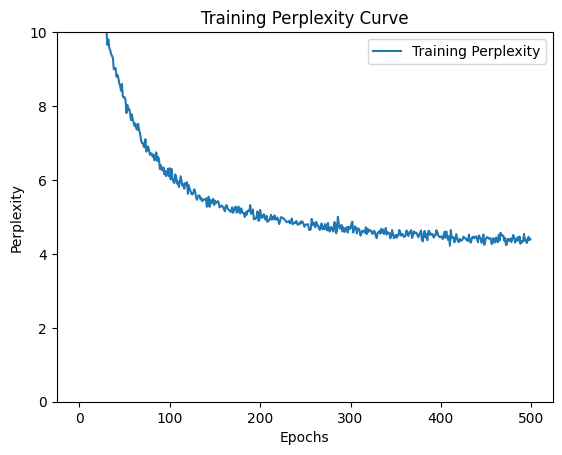

In [9]:
import matplotlib.pyplot as plt

epochs = len(all_losses)
plt.plot(range(epochs), all_losses, label='Training Perplexity')
plt.title('Training Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.ylim(0, 10)

# set the legend and display the plot
plt.legend()
plt.show()

## Task 2

In [10]:
decoder = torch.load('shakespeare.pt')

In [11]:
print(generate(decoder, prime_str='hj34s', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

hj34sd can with course to the crowns, are kneels word; you
As if Carish'd that out, I have see on your fe


In [12]:
print(generate(decoder, prime_str='2sf 4', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

2sf 4eith a mark her best forbertalous old you have persillerly face you do your commits we
Do see of my 


In [13]:
print(generate(decoder, prime_str='  3  ', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

  3  dear you plament
Upon repor mease the thinks thee, villain.

HENRY BOLINGBROKE:
Die the post first a


## Task 3

In [14]:
print(generate(decoder, prime_str='The', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

The see I will now keep?
Worthy wisdom send of.

GLOUCESTER:
Roman, spare though I have my great and Fr


In [15]:
print(generate(decoder, prime_str='What is', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

What is an of her solead
When I comina and shows done of the father.

WARWICK:
Then thou hails it it thou c


In [16]:
print(generate(decoder, prime_str='Shall I give', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

Shall I gives the chail of the purpose.

VOLUMNIA:
Peace hath thray unrich thee, peril that counture
And shall t


In [17]:
print(generate(decoder, prime_str='X087hNYB BHN BYFVuhsdbs', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

X087hNYB BHN BYFVuhsdbs of hath couth!
Has stars: I thou benity.

AUTOLYCUS:
What way boy!

KING RICHARD III:
We knows time


## Task 5

In [18]:
import re

file = re.sub(r"[^a-zA-Z\s]", "", file).lower()

all_words = list(dict.fromkeys(file.split()))
n_words = len(all_words)

# Turning a string into a tensor
def word_tensor(words):
    #words = string.split()
    tensor = torch.zeros(len(words)).long()
    for word in range(len(words)):
        try:
            tensor[word] = all_words.index(words[word])
        except:
            continue
    return tensor


In [19]:
#word_tensor("First Citizen: Before we proceed any further, hear me speak. All: Speak, speak.")

In [26]:
# Initialize models and start training

word_decoder = CharRNN(
    n_words,
    args.hidden_size,
    n_words,
    model=args.model,
    n_layers=args.n_layers,
)
word_decoder_optimizer = torch.optim.Adam(word_decoder.parameters(), lr=args.learning_rate)
word_criterion = nn.CrossEntropyLoss()

if args.cuda:
    word_decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

words = file.split()
words_len = len(words)

args.chunk_len = 20
args.n_epochs = 1000

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
    #for epoch in tqdm(range(1, 101)):
        loss = train(args, *random_training_set(args, file=words, file_len=words_len, tensor_fn=word_tensor), word_decoder, word_criterion, word_decoder_optimizer)
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(word_decoder, 'What', 20, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word = True), '\n')

    print("Saving...")
    save(args, word_decoder, "shakespeare_word")

except KeyboardInterrupt:
    print("Saving before quit...")
    save(args, word_decoder, "shakespeare_word")

Training for 1000 epochs...


 10%|█         | 100/1000 [00:18<02:44,  5.49it/s]

 18s (100 10%) 6.9118]
What and of is is we our tears shall hills his with his the katharina know me more the with to 



 20%|██        | 201/1000 [00:38<02:36,  5.10it/s]

 38s (200 20%) 6.8396]
What business camillo this we shall our be i son have would her from the his father sir with power that 



 30%|███       | 301/1000 [00:57<02:08,  5.44it/s]

 56s (300 30%) 6.7821]
What menenius of my your people for laurence i thy is it an i than you on for is who snarling 



 40%|████      | 401/1000 [01:17<01:52,  5.32it/s]

 17s (400 40%) 6.4375]
What parcels and be squared king are fearless to be supply and we break and have dukedom for thou children with 



 50%|█████     | 501/1000 [01:36<01:31,  5.45it/s]

 36s (500 50%) 6.2787]
What wicked that call you have are yet and told this to the smoothfaced and he in virtuous and my hate 



 60%|██████    | 601/1000 [01:56<01:16,  5.24it/s]

 55s (600 60%) 5.9353]
What motion a player i will blest this fardel then to grant them and thou do thou dost beseech and i 



 70%|███████   | 701/1000 [02:14<00:52,  5.67it/s]

 14s (700 70%) 5.6327]
What that you will i have passed give him by him and say you for him in love of your mettle 



 80%|████████  | 801/1000 [02:34<00:39,  5.07it/s]

 34s (800 80%) 5.5305]
What would will not be that shall i early foretells the grace to execution to us their enemy than mercy that 



 90%|█████████ | 901/1000 [02:53<00:17,  5.69it/s]

 53s (900 90%) 5.4465]
What senator for sir come you argued me between me adieu ay again what you are it than he shall be 



100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


 13s (1000 100%) 5.2166]
What art i dare make none not it please him why heres a thing but prevented on the indictment that we 

Saving...
Saved as shakespeare_word.pt


In [27]:
print(generate(word_decoder, 'The', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'The', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'The', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))

The tamed my heart and i could tell i am a friend a piece to my soul to my soul camillo not stand off to the purpose and that must go i have done it the duke of york the duke of norfolk duke of it hath been a piece and in the time king henry vi even to my life and thy brother but as this sirs horse to thee so sad to not a man a sail which it is bitter true by thy love and gentle childrens food to know at me a steepd or thy fancies had
The keeper or his pilgrimage that i deserve the rest was calling one would our halberds gross usurping horror the gods will be gone what is your honour my lord ross we may find you to play a great disguiser to my wars for if it ill leave him my own life and solemn must be no more dead a soul of lie and murders false confession and more nor given yet well for the wrong i have heard the souls of my heirs enforced the compass o thats the noble king richard iii my brother and must be the gracious
The gentleman my lord unto this man should hold the herdsmen of

In [28]:
print(generate(word_decoder, '.', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, '.', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, '.', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))


. citizen down and be not pleased it first gentleman it is news thou not jule second murderer me so should he would be conveyd with a purpose in his view in service for complaint than a downright bawd and aufidius let me fit poor a bawd this dispatchd there be not a note of the very mould and let him he he that so by him and cried you by his very hands his power to live he laugh his sweet sweet my grave true very play and it how not you look with a lawful very and we mean
. servant tis brotherlike and you in the supreme third servingman their eyes which i find them to the blemishd and in the keeping of him and is most royal knaves what we do second roman at the city we is soft ere you know you the doubt o the duke but though be not a mile to you inferrd and most good who is but cousin to a man the good clarence up the a thousand law so now it is the warlike soul more than one a gentleman and then hath shall of the bosom of god to the
. gentleman for it who be like you go they show the 

In [29]:
print(generate(word_decoder, 'which is,', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'which is,', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'which is,', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))


which is, murderer that i will make vex king richard ii thou sues lord marshal it would not be stabbd the game for speak and his death and and to god quoth i was it in the royalties for off and my followers or night not a man i should be satisfied what should prove with grief a word as old charity as we cannot who may we do all and did a man may be most slily thousand howling than one his coffers to their snow for fore their most tyrannical lord mayor you to the keys of our state and
which is, keeper so now what we have taen i am not almost noble lord edward iv i am who peers in substance of heavenly little buckingham of it with a few wife that thou desperately no more than your stones to find a royal place if i would take me to still such a thousand furlongs to a doleful whose western cheek with a book of the power of graves here upon the holy flag from a blot conduit of the city of the heavens and aim whose heed and yield him to the crown and a conduit of it when
which is, keeper to 

In [30]:
print(generate(word_decoder, 'blah blah blah', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'blah blah blah', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))
print(generate(word_decoder, 'blah blah blah', 100, cuda=args.cuda, tensor_fn=word_tensor, chars=all_words, word=True))


blah blah blah murderer he only the lord owe yourselves king richard iii thou foolish arms the queen that stabbd it up our troops of my soul be come we will leave us in cold friar at your succession your eyes of that looks to them out and almost toward the feather of great fools and more blows they find the rest hence in the flying and leads hold the spirits and thrust the title have our power of you to do you would depart to live that he did there should not be done into the way and be gone and the
blah blah blah senator his proper person he tells we have choke he began up to so and he has not to be very spent for us in our comfort as he would be advised and yet hath in a caitiff second murderer and either second gentleman true for that general in the issue and set to him from the edge and lay in the blood and if the kings people hast thou hair in the tomb is the kings body and begin he cried the and so shall be of a most than in our entertainment when deny with the time and
blah blah

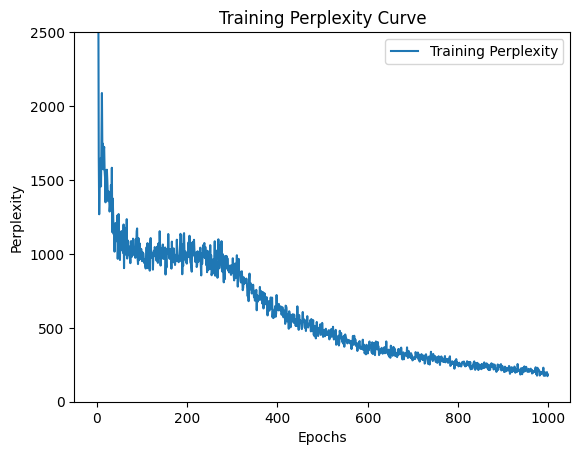

In [31]:
epochs = len(all_losses)
plt.plot(range(epochs), all_losses, label='Training Perplexity')
plt.title('Training Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.ylim(0, 2500)

# set the legend and display the plot
plt.legend()
plt.show()